In [1]:
import torch
import tqdm
from torch import nn
import torch.nn.functional as F
from torch import optim

from hydra import initialize, compose
from hydra.utils import instantiate
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from case_studies.dc2_diffusion.utils.catalog_parser import CatalogParser
from bliss.catalog import TileCatalog
from bliss.encoder.metrics import CatalogMatcher
from case_studies.dc2_diffusion.utils.metrics import DetectionPerformance
from case_studies.dc2_new_diffusion.utils.convnet_layers import C3, ConvBlock
from bliss.global_env import GlobalEnv

from case_studies.dc2_new_diffusion.utils.autoencoder import CatalogEncoder, CatalogDecoder

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
with initialize(config_path=".", version_base=None):
    new_diffusion_notebook_cfg = compose("latent_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.batch_size = 512
dc2.setup(stage="fit")
GlobalEnv.current_encoder_epoch = 1
GlobalEnv.seed_in_this_program = 7272
dc2_train_dataloader = dc2.train_dataloader()

catalog_parser: CatalogParser = instantiate(new_diffusion_notebook_cfg.encoder.catalog_parser)

In [4]:
target_ch = catalog_parser.n_params_per_source
encoder = CatalogEncoder(target_ch, hidden_dim=32)
decoder = CatalogDecoder(target_ch, hidden_dim=32 // 4)

In [5]:
encoder = encoder.to(device=device)
decoder = decoder.to(device=device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

### Train encoder and decoder with image weights

In [6]:
encoder.train()
decoder.train()

total_batch = len(dc2_train_dataloader)
epoch = 3
for _ in range(epoch):
    i = 0
    dc2_train_dataloader = dc2.train_dataloader()
    for batch in tqdm.tqdm(dc2_train_dataloader):
        batch = move_data_to_device(batch, device=device)
        target_cat = TileCatalog(batch["tile_catalog"])
        target_cat1 = target_cat.get_brightest_sources_per_tile(
            band=2, exclude_num=0
        )
        encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)
    
        optimizer.zero_grad()
        encoder_pred = encoder(encoded_catalog_tensor)
        image_weights = (torch.norm(batch["images"], dim=1, p=2, keepdim=True) * 100) + 1
        weighted_encoder_pred = encoder_pred * (1 / image_weights)
        recovered_target = decoder(weighted_encoder_pred)
        loss = ((recovered_target - encoded_catalog_tensor) ** 2).mean()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"step [{i + 1}/{total_batch}], loss: {loss.item():.6f}")
        i += 1
    GlobalEnv.current_encoder_epoch += 1

 27%|██▋       | 101/381 [00:39<01:29,  3.14it/s]

step [100/381], loss: 0.021697


 53%|█████▎    | 201/381 [01:12<00:57,  3.14it/s]

step [200/381], loss: 0.014397


 79%|███████▊  | 300/381 [01:45<00:31,  2.61it/s]

step [300/381], loss: 0.001368


 26%|██▌       | 100/381 [00:39<01:50,  2.54it/s]

step [100/381], loss: 0.000356


 53%|█████▎    | 201/381 [01:13<00:53,  3.38it/s]

step [200/381], loss: 0.000361


 79%|███████▉  | 301/381 [01:47<00:24,  3.28it/s]

step [300/381], loss: 0.000263


 26%|██▌       | 100/381 [00:43<01:49,  2.57it/s]

step [100/381], loss: 0.000155


 53%|█████▎    | 201/381 [01:18<00:55,  3.24it/s]

step [200/381], loss: 0.000118


 79%|███████▉  | 301/381 [01:52<00:26,  3.05it/s]

step [300/381], loss: 0.000123


100%|██████████| 381/381 [02:21<00:00,  2.69it/s]


### Test encoder and decoder

In [7]:
matcher = CatalogMatcher(dist_slack=1.0)
f1_metric = DetectionPerformance().to(device=device)
dc2_val_dataloader = dc2.val_dataloader()

In [8]:
encoder.eval()
decoder.eval()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(batch["tile_catalog"])
    target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2,  exclude_num=0)
    target_full_cat = target_tile_cat.to_full_catalog(tile_slen)

    encoded_catalog_tensor = catalog_parser.encode(target_tile_cat).permute([0, 3, 1, 2])  # (b, k, h, w)
    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
        image_weights = (torch.norm(batch["images"], dim=1, p=2, keepdim=True) * 100) + 1
        weighted_encoder_pred = encoder_pred * (1 / image_weights)
        recovered_target = decoder(weighted_encoder_pred)
    recovered_target = catalog_parser.clip_tensor(recovered_target.permute([0, 2, 3, 1]))
    recovered_tile_cat = catalog_parser.decode(recovered_target)
    recovered_full_cat = recovered_tile_cat.to_full_catalog(tile_slen)

    matching = matcher.match_catalogs(target_full_cat, recovered_full_cat)
    f1_metric.update(target_full_cat, recovered_full_cat, matching)

100%|██████████| 49/49 [00:27<00:00,  1.78it/s]


In [9]:
for k, v in f1_metric.compute().items():
    print(f"{k}: {v}")

detection_precision: 0.9928956627845764
detection_recall: 0.9926221966743469
detection_f1: 0.9927588701248169
n_true_sources: 152484.0
n_est_sources: 152442.0


### Train a new decoder without image weights

In [10]:
new_decoder = CatalogDecoder(target_ch, hidden_dim=32 // 4)
new_decoder = new_decoder.to(device=device)
new_optimizer = optim.Adam(new_decoder.parameters(), lr=1e-3)

In [11]:
encoder.eval()
new_decoder.train()

total_batch = len(dc2_train_dataloader)
epoch = 3
for _ in range(epoch):
    i = 0
    dc2_train_dataloader = dc2.train_dataloader()
    for batch in tqdm.tqdm(dc2_train_dataloader):
        batch = move_data_to_device(batch, device=device)
        target_cat = TileCatalog(batch["tile_catalog"])
        target_cat1 = target_cat.get_brightest_sources_per_tile(
            band=2, exclude_num=0
        )
        encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)
    
        new_optimizer.zero_grad()
        with torch.no_grad():
            encoder_pred = encoder(encoded_catalog_tensor)
        recovered_target = new_decoder(encoder_pred)
        loss = ((recovered_target - encoded_catalog_tensor) ** 2).mean()
        loss.backward()
        new_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"step [{i + 1}/{total_batch}], loss: {loss.item():.6f}")
        i += 1
    GlobalEnv.current_encoder_epoch += 1

 27%|██▋       | 101/381 [00:40<00:51,  5.43it/s]

step [100/381], loss: 0.003129


 52%|█████▏    | 200/381 [01:15<00:30,  6.01it/s]

step [200/381], loss: 0.000582


 79%|███████▉  | 301/381 [01:53<00:43,  1.83it/s]

step [300/381], loss: 0.000287


 26%|██▌       | 100/381 [00:39<01:25,  3.30it/s]

step [100/381], loss: 0.000182


 53%|█████▎    | 201/381 [01:14<00:31,  5.67it/s]

step [200/381], loss: 0.000165


 79%|███████▉  | 301/381 [01:47<00:12,  6.65it/s]

step [300/381], loss: 0.000146


 26%|██▌       | 100/381 [00:38<01:11,  3.94it/s]

step [100/381], loss: 0.000125


 53%|█████▎    | 201/381 [01:14<00:29,  6.10it/s]

step [200/381], loss: 0.000105


 79%|███████▊  | 300/381 [01:49<00:14,  5.65it/s]

step [300/381], loss: 0.000101


100%|██████████| 381/381 [02:19<00:00,  2.74it/s]


### Test this new decoder

In [12]:
matcher = CatalogMatcher(dist_slack=1.0)
f1_metric = DetectionPerformance().to(device=device)
dc2_val_dataloader = dc2.val_dataloader()

In [13]:
encoder.eval()
new_decoder.eval()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(batch["tile_catalog"])
    target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2,  exclude_num=0)
    target_full_cat = target_tile_cat.to_full_catalog(tile_slen)

    encoded_catalog_tensor = catalog_parser.encode(target_tile_cat).permute([0, 3, 1, 2])  # (b, k, h, w)
    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
        recovered_target = new_decoder(encoder_pred)
    recovered_target = catalog_parser.clip_tensor(recovered_target.permute([0, 2, 3, 1]))
    recovered_tile_cat = catalog_parser.decode(recovered_target)
    recovered_full_cat = recovered_tile_cat.to_full_catalog(tile_slen)

    matching = matcher.match_catalogs(target_full_cat, recovered_full_cat)
    f1_metric.update(target_full_cat, recovered_full_cat, matching)

100%|██████████| 49/49 [00:27<00:00,  1.79it/s]


In [14]:
for k, v in f1_metric.compute().items():
    print(f"{k}: {v}")

detection_precision: 0.9929293990135193
detection_recall: 0.9927861094474792
detection_f1: 0.9928577542304993
n_true_sources: 152484.0
n_est_sources: 152462.0


In [15]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(new_decoder.state_dict(), "decoder.pt")

### Plotting

In [42]:
import matplotlib.pyplot as plt

In [43]:
image_index = 6

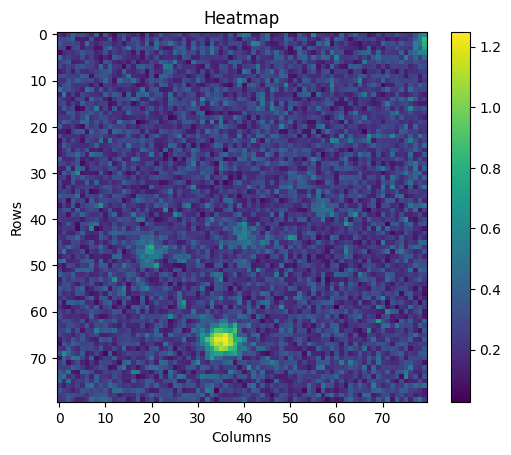

In [44]:
plt.imshow((batch["images"][image_index].norm(dim=0, p=2) + 1).log().cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [45]:
encoder_pred.max(), encoder_pred.min()

(tensor(16.5251, device='cuda:1'), tensor(0., device='cuda:1'))

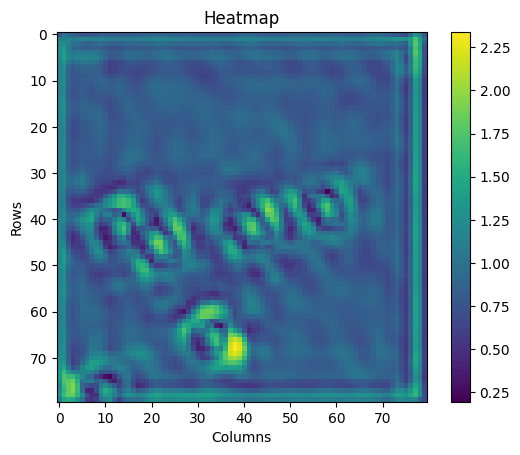

In [46]:
plt.imshow((encoder_pred[image_index].norm(dim=0, p=2) + 1).log().cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

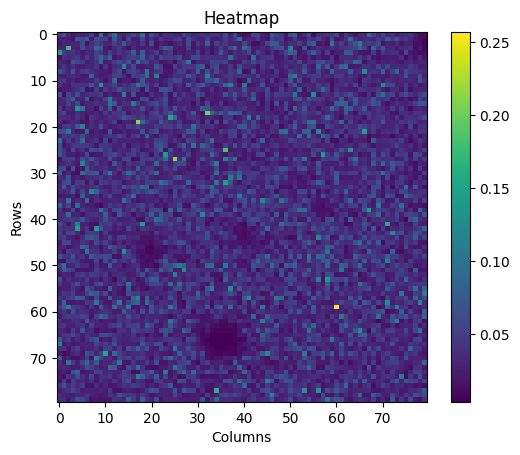

In [47]:
plt.imshow((1 / (batch["images"][image_index].norm(dim=0, p=2) * 100 + 1)).cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

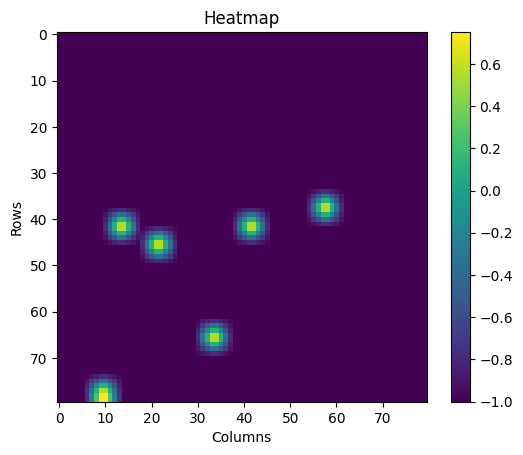

In [48]:
upsampled_cat_tensor = F.interpolate(encoded_catalog_tensor, scale_factor=4, mode="bilinear")
plt.imshow(upsampled_cat_tensor[image_index, 0].cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

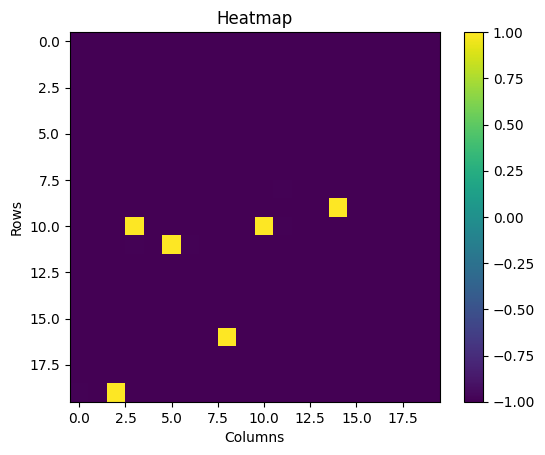

In [49]:
plt.imshow(recovered_target.permute([0, 3, 1, 2])[image_index, 0].cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

### Get min and max

In [24]:
encoder.eval()

dc2_train_dataloader = dc2.train_dataloader()
encoder_pred_max = -torch.inf
encoder_pred_min = torch.inf
for batch in tqdm.tqdm(dc2_train_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_cat = TileCatalog(batch["tile_catalog"])
    target_cat1 = target_cat.get_brightest_sources_per_tile(
        band=2, exclude_num=0
    )
    encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)

    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor, batch["images"])
    if encoder_pred.max() > encoder_pred_max:
        encoder_pred_max = encoder_pred.max()
    if encoder_pred.min() < encoder_pred_min:
        encoder_pred_min = encoder_pred.min()

dc2_val_dataloader = dc2.val_dataloader()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_cat = TileCatalog(batch["tile_catalog"])
    target_cat1 = target_cat.get_brightest_sources_per_tile(
        band=2, exclude_num=0
    )
    encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)

    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor, batch["images"])

    if encoder_pred.max() > encoder_pred_max:
        encoder_pred_max = encoder_pred.max()
    if encoder_pred.min() < encoder_pred_min:
        encoder_pred_min = encoder_pred.min()

100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


In [25]:
encoder_pred_min, encoder_pred_max

(tensor(0., device='cuda:1'), tensor(22.4741, device='cuda:1'))